# FedSpeak Language Modeling

_Attention is all you need_ - Vaswani et al

Concepts:
- Transformers
- Language modeling

References:
- https://pytorch.org/tutorials/beginner/transformer_tutorial.html
- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. Attention Is All You Need. 


In [1]:
from typing import Callable, List
import math
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import bisect
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize as tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torchinfo
from tqdm import tqdm
from finds.database.mongodb import MongoDB
from finds.unstructured import Unstructured, Vocab
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [2]:
mongodb = MongoDB(**credentials['mongodb'], verbose=VERBOSE)
fomc = Unstructured(mongodb, 'FOMC')
outdir = paths['scratch']
device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [3]:
# Retrieve and preprocess FOMC minutes text
dates = fomc['minutes'].distinct('date')       # check dates stored in MongoDB
docs = Series({doc['date']: [w.lower() for w in tokenize(doc['text'])]
               for doc in fomc.select('minutes')},
              name='minutes').sort_index()
UNK = " "
vocab = Vocab(set().union(*docs.tolist()), unk=UNK)
print(len(vocab))

8622


In [4]:
# Pytorch Dataset and DataLoader
class FOMCDataset(Dataset):
    """Subclass of torch Dataset

    Notes:
      All subclasses should overwrite __getitem__(),
      supporting fetching a data sample for a given key. Subclasses
      could also optionally overwrite __len__(), which is expected to
      return the size of the dataset
    """
    def __init__(self, text: Series, seq_len: int, get_index: Callable[[str], int]):
        self.text = text
        self.seq_len = seq_len
        self.get_index = get_index
        self.counts = np.cumsum([len(s) // seq_len for s in text])

    def __len__(self):
        return self.counts[-1]

    def __getitem__(self, idx):
        assert 0 <= idx < len(self), "idx out of range"
        doc = bisect.bisect_right(self.counts, idx)

        start = (idx - (self.counts[doc-1] if doc > 0 else 0)) * self.seq_len
        end = start + self.seq_len
        chunk = self.text.iloc[doc][start:end]
        return (torch.LongTensor([0] + self.get_index(chunk[:-1])),
                torch.LongTensor(self.get_index(chunk)))

In [5]:
# length of input sequence
seq_len = 30 # 40 # 20

In [6]:
# split last document to be test set
test_len = 1
test_set = docs.iloc[-test_len:].tolist()
train_set = FOMCDataset(docs.iloc[:-test_len], seq_len, vocab.get_index)
dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
DataFrame({'docs': len(docs)-test_len, 'chunks': len(train_set)}, index=['Train'])

,docs,chunks
Train,248,53336


## Transformers


In [7]:
class Transformer(nn.Module):
    def __init__(self, seq_len: int, vocab_size: int, d_model: int, nhead: int,
                 num_layers: int, dim_feedforward: int, dropout: float):
        super().__init__()

        # model dimensions
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.d_model = d_model

        # define layers
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=d_model)
        self.positional = PositionalEncoding(max_len=seq_len,
                                             d_model=d_model,
                                             dropout=dropout)

        layer = nn.TransformerEncoderLayer(d_model=d_model,
                                           nhead=nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout,
                                           batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer=layer,
                                             num_layers=num_layers)
        self.decoder = nn.Linear(in_features=d_model,
                                 out_features=vocab_size)

        # initialize weights
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.decoder.weight.data.uniform_(-0.1, 0.1)
        self.decoder.bias.data.zero_()

    def causal_mask(self, sz: int, device: str = 'cpu'):
        """returns upper triu set to -inf"""
        return nn.Transformer.generate_square_subsequent_mask(sz=self.seq_len,
                                                              device=device)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x[None, :]
        assert x.size(-1) == self.seq_len
        x = self.embedding(x) * math.sqrt(self.d_model)  # embedding
        x = self.positional(x)                           # position encoding
        x = self.encoder(x, mask=self.causal_mask(sz=len(x), device=x.device))
        x = self.decoder(x)                              # linear layer
        x = F.log_softmax(x, dim=-1)                     # classify
        return x

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self

### Positional Encoding


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int, dropout: float= 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.emb = nn.Embedding(num_embeddings=max_len, embedding_dim=d_model)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        to_embed = torch.LongTensor(np.asarray(range(0, x.size(1))))\
                        .to(x.device)
        embedded = self.emb(to_embed)
        embedded = self.dropout(embedded)
        return x + embedded.unsqueeze(0)
    
    """
    def __init__(self, d_model: int, max_len: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)
                             * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe[:, None, :] 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), 0, :]
        return self.dropout(x)
    """

## Language modeling


### Perplexity


In [9]:
def get_next_log_probs(model, context: List[str], unk=UNK):
    """log P(word | context) where word ranges over the vocab"""

    # pad to length seq_len
    if len(context) > model.seq_len:
        context = context[-model.seq_len:]
    elif len(context) < model.seq_len:
        context = ([unk] * (model.seq_len - len(context))) + context
    assert len(context) == model.seq_len

    context = torch.LongTensor(vocab.get_index(context))\
                   .to(device)\
                   .unsqueeze(0)
    output = model(context)
    logits = output[0, -1, :] 
    return logits.cpu().detach().numpy()

In [10]:
def get_log_prob_sequence(model, next_words: List[str], context: List[str] = []):
    """Scores a bunch of characters following context"""
    if not context:
        context = [UNK]
    context = context + next_words
    
    log_probs = 0
    for i in range(len(context) - len(next_words), len(context)):
        log_prob = get_next_log_probs(model=model, context=context[:i])
        log_probs += log_prob[vocab.get_index(context[i])]
    return log_probs

In [11]:
def get_perplexity(model, context: List[str]) -> float:
    """Compute perpexlity score"""
    log_prob = get_log_prob_sequence(model=model, next_words=context, context=[])
    return np.exp(-log_prob / len(context))

In [12]:
# Create the model
lr = 0.0001
step_size = 30
num_epochs = 50 #step_size * 1

In [13]:
d_model = 256 #512
nhead = 4 # 4
num_layers = 3 # 2
dim_feedforward = 2048 # 512 #1024
dropout = 0.2 # 0.3 # 0.2

In [14]:
model = Transformer(seq_len=seq_len,
                    vocab_size=len(vocab), 
                    d_model=d_model, 
                    nhead=nhead,
                    num_layers=num_layers,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout).to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
Transformer                                                       --
├─Embedding: 1-1                                                  2,207,232
├─PositionalEncoding: 1-2                                         --
│    └─Dropout: 2-1                                               --
│    └─Embedding: 2-2                                             7,680
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          1,315,072
│    │    └─TransformerEncoderLayer: 3-2                          1,315,072
│    │    └─TransformerEncoderLayer: 3-3                          1,315,072
├─Linear: 1-4                                                     2,215,854
Total params: 8,375,982
Trainable params: 8,375,982
Non-trainable params: 0

In [15]:
# Train the model
criterion = nn.NLLLoss().to(device)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

/home/terence/env3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
perplexity = []
losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for train_ex, target_ex in dataloader:
        optimizer.zero_grad()
        train_ex, target_ex = train_ex.to(device), target_ex.to(device)
        output = model(train_ex)
        loss = criterion(output.view(-1, len(vocab)), target_ex.view(-1))
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    # Evaluate perplexity on test set
    model.eval()
    perplexity.append(np.mean([get_perplexity(model, s) for s in test_set]))
    losses.append(loss.item())
    if VERBOSE:
        print(f"Epoch: {epoch}, Loss: {loss.item()}, Perplexity: {perplexity[-1]}")
model.save(outdir / f"transformer{nhead}_{dim_feedforward}.pt")

100%|██████████| 50/50 [21:17<00:00, 25.55s/it]


In [17]:
model.load(outdir / f"transformer{nhead}_{dim_feedforward}.pt")

Transformer(
  (embedding): Embedding(8622, 256)
  (positional): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
    (emb): Embedding(30, 256)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=256, out_features=8622, bias=True)
)

Perplexity: 11.667960207233376   Loss: 2.023679733276367


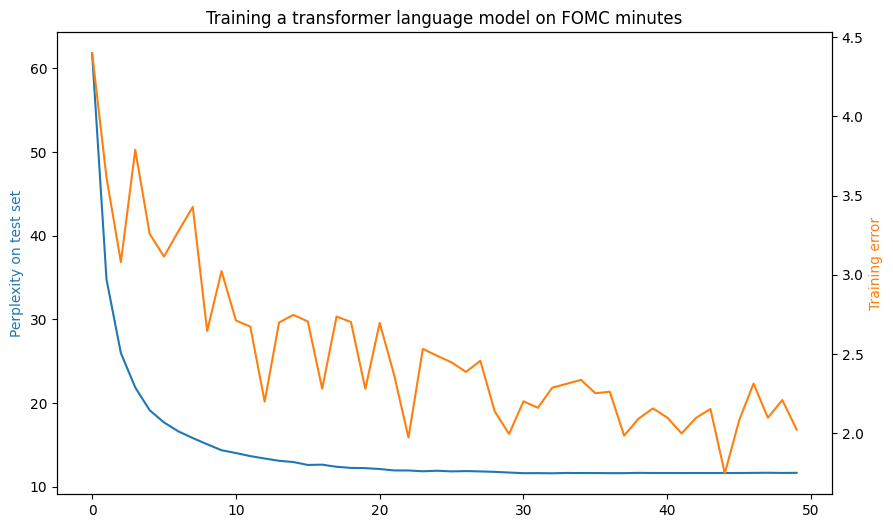

In [18]:
# Plot perplexity
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(perplexity, color="C0")
ax.set_ylabel('Perplexity on test set', color="C0")
bx = ax.twinx()
bx.plot(losses, color="C1")
bx.set_ylabel('Training error', color="C1")
plt.title('Training a transformer language model on FOMC minutes')
print('Perplexity:', perplexity[-1], '  Loss:', losses[-1])

### Nuclear sampling


In [19]:
def get_nuclear_sequence(model, n: int, p: float, context: List[str] = []):
    """Sample sequence of words given context"""
    if not context:
        context = [UNK]
    
    for i in range(n):
        probs = np.exp(get_next_log_probs(model, context))
        probs_sorted = sorted(probs, reverse=True)
        probs_cum = np.cumsum(probs_sorted)
        num_drop = sum(probs_cum > p)
        threshold = probs_sorted[-num_drop]
        probs[probs < threshold] = 0.
        probs /= sum(probs)
        choice = vocab.get_word(np.random.choice(len(probs), p=probs))
        context.append(choice)
        #print(i, drop, len(probs), len(probs_sorted))
    return context

In [20]:
import textwrap
wrapper = textwrap.TextWrapper(width=80, fix_sentence_endings=True)

Finally, generate language with nuclear sampling given starting contexts

In [23]:
n, p = seq_len * 2, 0.95
for context in ['the financial markets' , 'participants noted that']:

    # generate from context with nuclear sampling
    words = get_nuclear_sequence(model, n=n, p=p, context=context.split())

    # pretty-print the output
    out = ''
    is_end = True
    is_space = ''
    for w in words:
        if not w.isalnum():
            out += w
        else:
            if is_end:
                w = w.capitalize()
            out += is_space + w
        is_end = w in ['!', '?', '.']
        is_space = ' '*bool(w not in ["'", '-', '–'])
    print(f"{context.upper()}...")
    print(wrapper.fill(out))
    print()

THE FINANCIAL MARKETS...
The financial markets that had occurred in mortgage interest rates since the
start of 2014. Consequently, the committee anticipates that it will be
appropriate to maintain the target range for the federal funds rate at 0 to 1/ 4
percent.  The committee directs the desk to purchase gse debt and agency
mortgage-backed securities( mbs) the

PARTICIPANTS NOTED THAT...
Participants noted that overall financial conditions remained accommodative, in
part reflecting policy measures to support the economy.  They noted that since
midyear, a tightening was necessary, though the unemployment rate remained
elevated.  Some participants suggested that underlying growth in consumption
expenditures remained sluggish, likely reflecting growth in the output of high-
tech equipment.  Nonetheless,

